# Experimental Notebook

In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse

from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_37809/2520264742.py:18: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [3]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

## AC Stark-Shift based RR Kappa (T1) Charecterisation

In [4]:
from utils import get_dt_from, convert_arr_to_dt, acquisition_checker

ac_freq_low = -22.5 * MHz
ac_freq_high = 2.5 * MHz
num_ac_exp = 99
ac_freq_linspace = np.linspace(ac_freq_low, ac_freq_high, num_ac_exp)
ac_freq_precision = int(1e3*(ac_freq_linspace[1] - ac_freq_linspace[0]) / MHz)/1e3

print(f"AC Freq Precision: {ac_freq_precision}MHz")

## Constant Amplitude RR Tone Details
rr_meas_duration_ns = 2 * measure_pulse.duration * ns
rr_meas_amp = measure_pulse.amp

delay_back_shift_ns = -get_dt_from(20 * ns) * dt
delays_high = 300.0 * ns
num_delays_exp = 12
delays_linspace = np.linspace(delay_back_shift_ns, delay_back_shift_ns + delays_high, num_delays_exp)
delays_linspace = convert_arr_to_dt(delays_linspace)
print(delays_linspace/ns)

print(f"Total Experiment Size: {num_ac_exp * num_delays_exp}")

AC Freq Precision: 0.255MHz
[-21.33333333   7.11111111  32.          60.44444444  88.88888889
 113.77777778 142.22222222 170.66666667 195.55555556 224.
 252.44444444 277.33333333]
Total Experiment Size: 1188


In [5]:
big_jobs = []

for qubit_delay_ns in delays_linspace:
    qubit_delay_dt = get_dt_from(qubit_delay_ns)

    for ac_freq_shift in ac_freq_linspace:
        with pulse.build(
            backend=backend,
            default_alignment='left',
            name=f'AC Freq Shift: {int(1e3*ac_freq_shift/1e6)/1e3}MHz, Qubit Tone Delay: {int(1e3*qubit_delay_dt*dt/ns)/1e3}ns'
        ) as freq_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)

            pulse.shift_frequency(ac_freq_shift, qubit_chan)
            pulse.play(
                pulse.Constant(
                    duration=get_dt_from(rr_meas_duration_ns),
                    amp=rr_meas_amp
                ),
                meas_chan
            )
            pulse.delay(
                get_dt_from(rr_meas_duration_ns) + qubit_delay_dt,
                qubit_chan
            )
            pulse.play(
                x_pulse,
                qubit_chan
            )
            pulse.delay(
                measure_delay.duration,
                meas_chan
            )
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        big_jobs.append(freq_sched)

print(len(big_jobs))
acquisition_checker(big_jobs)

1188


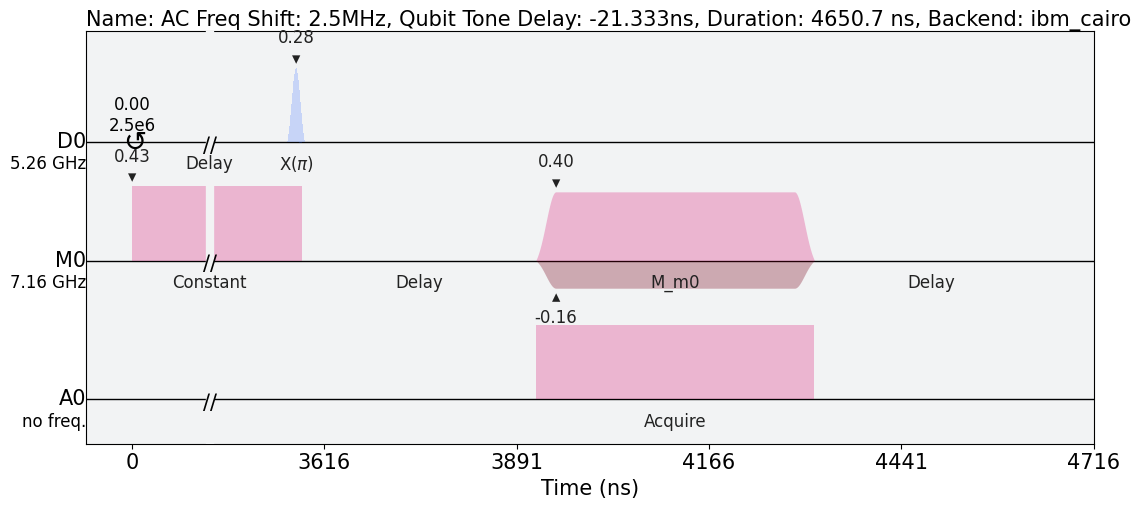

In [6]:
big_jobs[98].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

297


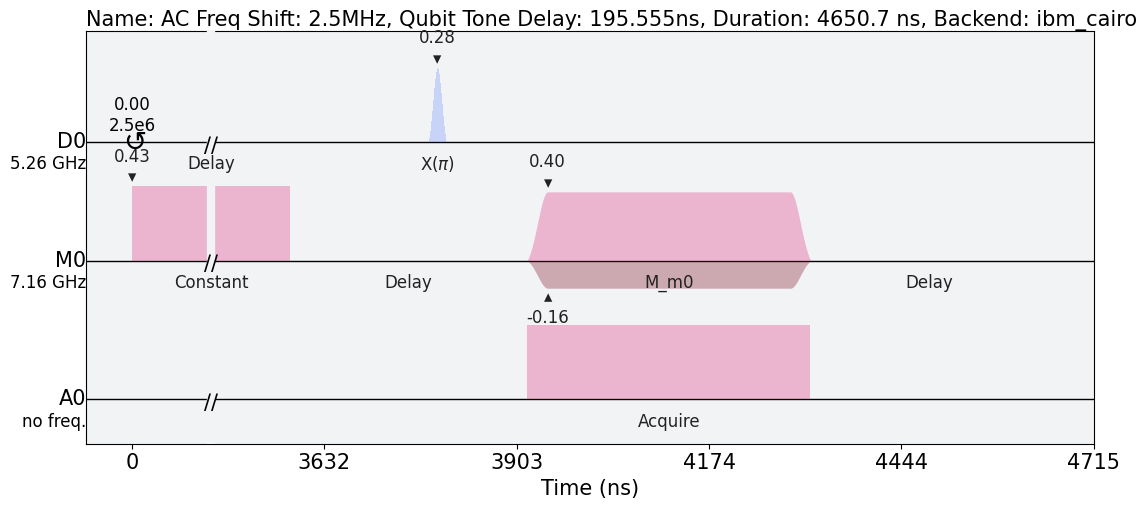

In [7]:
num_shots = 4096
rep_delay = 499.0 * 1e-6

job_1, job_2, job_3, job_4 = np.array(big_jobs).reshape(4, -1).tolist()

print(len(job_1))

job_3[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [11]:
# Running job_1, job_2, job_3, job_4

job_experiment = backend.run(job_4, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued

KeyboardInterrupt: 

In [8]:
job_1 = provider.backend.retrieve_job('cpkxs04f7dt0008vk7kg')
job_2 = provider.backend.retrieve_job('cpkxs2msypyg008fcv10')
job_3 = provider.backend.retrieve_job('cpkxs54sypyg008fcv20')
job_4 = provider.backend.retrieve_job('cpkxs85f7dt0008vk7m0')

In [9]:
from utils import get_results_arr

results_1 = get_results_arr(job_1.result(), qubit)
results_2 = get_results_arr(job_2.result(), qubit)
results_3 = get_results_arr(job_3.result(), qubit)
results_4 = get_results_arr(job_4.result(), qubit)

In [10]:
big_results = np.concatenate((results_1, results_2, results_3, results_4), axis=0).reshape(num_delays_exp, num_ac_exp, num_shots)
big_mean_res = np.angle(np.mean(big_results, axis=-1))

pre_reset_res = big_mean_res[0]
kappa_res = big_mean_res[1:]

In [11]:
print(pre_reset_res.shape)
print(kappa_res.shape)

(99,)
(11, 99)


In [20]:
## Fitting Gaussians to each of the AC Stark-Shift Spec data
## to determine center frequencies (in other words photon populations)

from scipy.optimize import curve_fit

big_mean_fit_res = np.zeros_like(big_mean_res)
big_mean_center_freqs = np.zeros(big_mean_res.shape[0])

def g_func(x, A, u, s, offset):
    return A * np.exp(-(x - u)**2 / (2 * s**2)) + offset

f_linspace = ac_freq_linspace / MHz

for ind, res in enumerate(big_mean_res):
    init_params = [0.1, -10.0, 5.0, -1.1]
    params, cov = curve_fit(g_func, f_linspace, res, init_params, maxfev=2000)
    big_mean_center_freqs[ind] = params[1]
    big_mean_fit_res[ind] = g_func(f_linspace, *params)

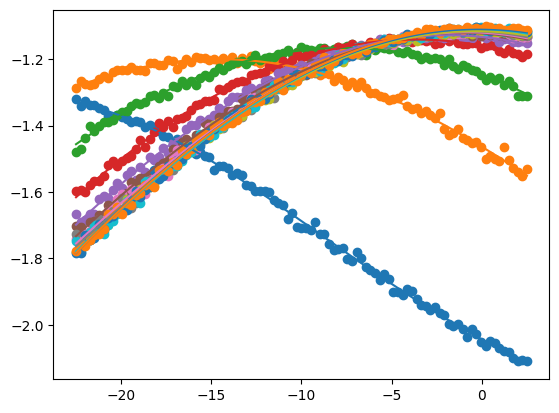

In [21]:
for scatter_res in big_mean_res:
    plt.scatter(f_linspace, scatter_res)
plt.plot(f_linspace, big_mean_fit_res.T)
plt.show()

exp N0: 40.759026200086204


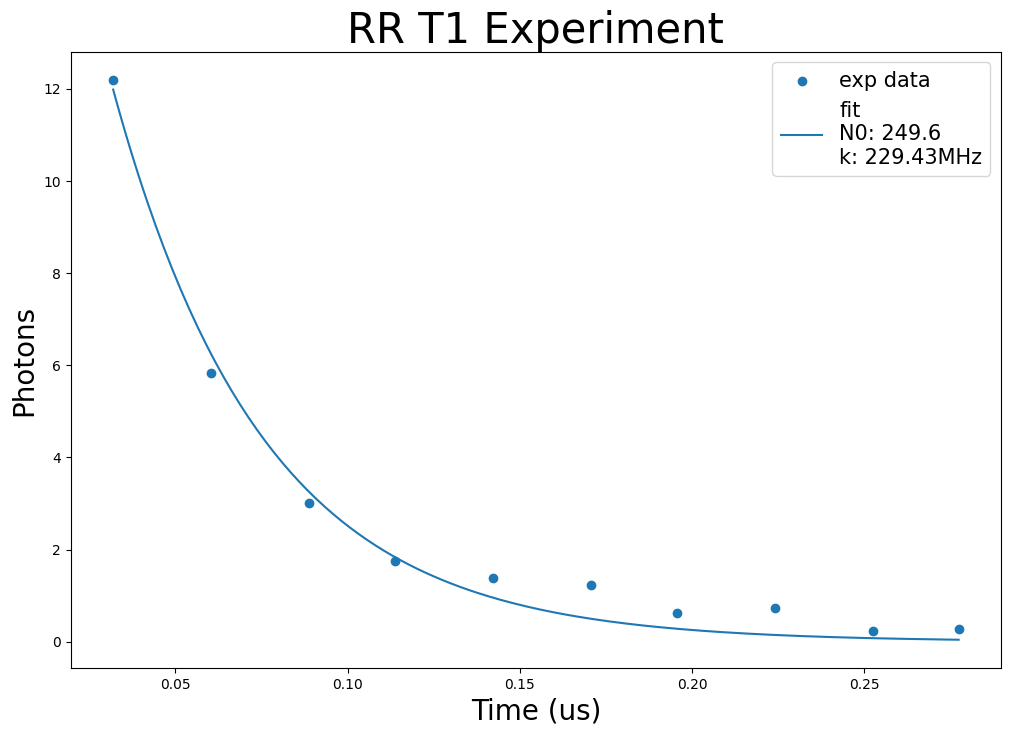

In [44]:
## Now fitting an exponential decay fit to the Photon Populations vs Time

start_ind = 2

chi = -0.63

print(f"exp N0: {big_mean_center_freqs[0] / chi}")

t_data = delays_linspace[start_ind:]/us
photon_data = big_mean_center_freqs[start_ind:] / chi

t_plot = np.linspace(t_data[0], t_data[-1], num=201)

def exp_func(t, A, k):
    return A * np.exp(-k * t)

init_params = [40.0, 25.0]
exp_params, exp_cov = curve_fit(exp_func, t_data, photon_data, init_params, maxfev=2000)

fit_res_plot = exp_func(t_plot, *exp_params)

fit_N0, fit_kappa = (np.array(exp_params) * 1e3).astype(np.int32) / 1e2

plt.figure(figsize=(12.0, 8.0))
plt.scatter(t_data, photon_data, label='exp data')
plt.plot(
    t_plot, 
    fit_res_plot, 
    label=f'fit\nN0: {fit_N0}\nk: {fit_kappa}MHz'
    )
plt.xlabel('Time (us)', fontsize=20)
plt.ylabel('Photons', fontsize=20)
plt.title('RR T1 Experiment', fontsize=30)
plt.legend(fontsize=15)
plt.show()